So we saw that there were hits identified all at the same frequency and with zero drift rate in all the signals. We'd like to know if this is a signature of the single antenna RFI (SARFI) or maybe something else by looking at the stamp files, which we'll do here



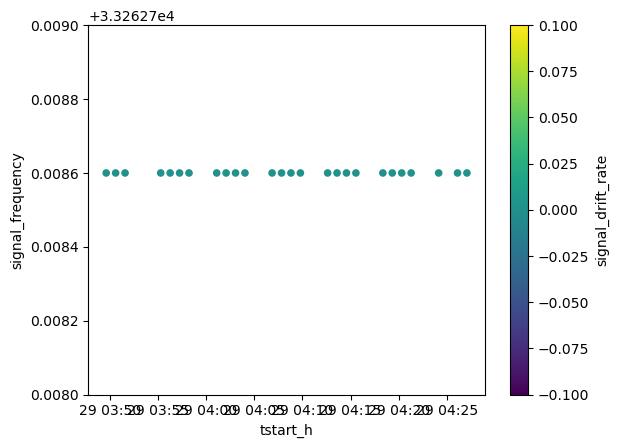

### Setup

In [1]:
# Import packages needed
import numpy as np
import pandas as pd
import pickle
import os
os.environ["H5PY_DEFAULT_READONLY"] = "1" # Surpress h5py deprecation warnings
import socket
from datetime import datetime
from seticore import viewer # If you don't have it, use pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
import matplotlib.pyplot as plt

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/nstiegle


In [2]:
# Load in the information of the hits we want to look at
df = pd.read_csv("/home/nstiegle/BL-COSMIC-2024-proj/frequency_adjacency/stamps_of_flat_rfi/stamps_of_flat_rfi.csv")
print(df.shape)

(26, 16)


In [3]:
# Look for the stamp in a single stamp file
# Assumes the stamp_uri exists 
def find_stamp_in_single_file(stamp_uri, hit_frequency, threshold):
    # Check each stamp in the file to see if it matches
    stamps_gen = viewer.read_stamps(stamp_uri, find_recipe=True)
    for i, stamp in enumerate(stamps_gen):
        assert(stamp != None)
        assert(stamp.recipe != None)
        if abs(stamp.stamp.signal.frequency - hit_frequency) < threshold*1e-6:
            # Found the stamp!
            return i, stamp
    
    # Didn't find the stamp in this whole file of stamps
    return None, None

# Given a stamp_uri, increments the index of the stamp file by one (so if it's /.../...seticore.0000.stamps it goes to /.../...seticore.0001.stamps)
def increment_stamp_uri(stamp_uri):
    split_uri = stamp_uri.split('.')
    assert(split_uri[-1] == 'stamps')
    num = int(split_uri[-2])
    num += 1
    split_uri[-2] = str(num).zfill(4)
    return ".".join(split_uri)

# Finds where the stamp of a given hit is
# Takes:
# - stamp URI (of stamp file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location_helper(stamp_uri, hit_frequency, threshold):
    # Check stamp file passed in exists
    if not os.path.exists(stamp_uri):
        return None, None
    
    # Look for stamp in the stamp file given
    index, stamp = find_stamp_in_single_file(stamp_uri, hit_frequency, threshold)
    if (index != None) and (stamp != None):
        return stamp_uri, index
    else:
        # Check if there's another stamp file (because stamps can get split up into multiple files)
        return find_stamp_location_helper(increment_stamp_uri(stamp_uri), hit_frequency, threshold)

# Finds where the stamp of a given hit is
# Takes:
# - hit URI (of .hits file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location(hit_uri, hit_frequency, threshold=500):
    # Convert a filepath from pointing to a .hits
    # to a .stamps file for the same uri
    # If given a .stamps ending, doesn't change it
    def stamp_filepath_of(hits_filepath):
        return hits_filepath.replace('.hits', '.0000.stamps')

    return find_stamp_location_helper(stamp_filepath_of(hit_uri), hit_frequency, threshold)

### Look at stamps

In [4]:
# Find the stamp_uri and the index in the stamp for each hit
stamp_uris = []
indices_in_stamps = []
for i, row in df.iterrows():
    stamp_uri, index_in_stamp = find_stamp_location(row.file_uri, row.signal_frequency)
    stamp_uris.append(stamp_uri)
    indices_in_stamps.append(index_in_stamp)

df["stamp_uri"] = stamp_uris
df["stamp_index"] = indices_in_stamps

In [5]:
# Get the first stamp just to look at 
i = 0
stamps = [stamp for stamp in viewer.read_stamps(df["stamp_uri"][i], find_recipe=True)]
stamp = stamps[df["stamp_index"][i]]
assert(stamp != None)
assert(stamp.recipe != None)
# stamp.show_antennas() # It's big - single antenna RFI :(

In [6]:
# Let's go through and save out these plots for each stamp so I can look at them
for i in range(len(df)):
    stamps = [stamp for stamp in viewer.read_stamps(df["stamp_uri"][i], find_recipe=True)]
    stamp = stamps[df["stamp_index"][i]]
    assert(stamp != None)
    assert(stamp.recipe != None)
    stamp.show_antennas(title=f"Stamp {i}", save_to=f"/home/nstiegle/BL-COSMIC-2024-proj/frequency_adjacency/stamps_of_flat_rfi/stamp_{i}.png")

In [10]:
# They're all single antenna RFI from ea23
print(df.signal_frequency.unique()[0], "MHz")

33262.708599607846 GHz
